In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 2*8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-17 16:08:58.275772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 16:08:58.492632: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-17 16:08:59.135381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Note to remember
# In this form of reshaping the datasets, u, u_xx, u_yy, u_t, v, v_xx and v_yy, v_t must be transposed to correctly show x and y coordinates

# This note book use only one snapshot (the last), does not estimate the time derivatives and use the exact u and v to reduce the loss residual. FInaly, the parameters are constant.

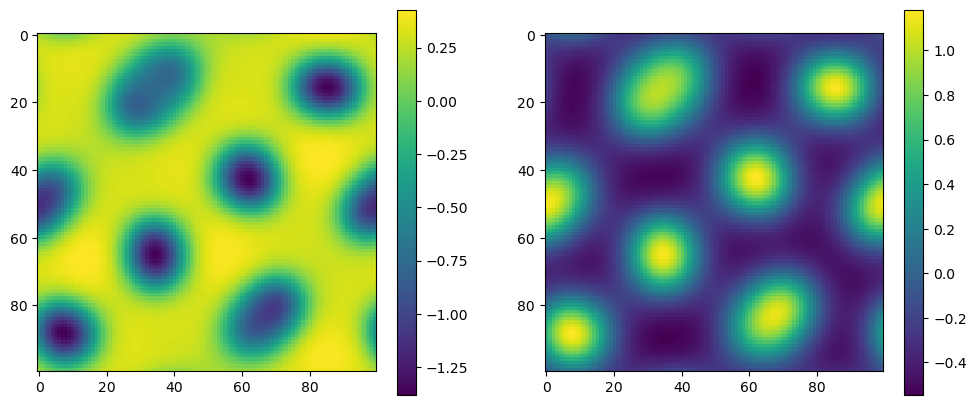

In [3]:
sim_name = "Koch_Meinhardt_1"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-16,
               data_time_len=12,
               data_time_step=1)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]


plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [4]:
def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        H = pinn.make_inputs(ts)
        tape.watch(H)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)            
            outputs = pinn.net(H)            
        
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
        grad_u = tape2.gradient(u, H)
        u_x = grad_u[:, :, :, 0]
        u_y = grad_u[:, :, :, 1]
        u_t = grad_u[:, :, :, 2]

        grad_v = tape2.gradient(v, H)
        v_x = grad_v[:, :, :, 0]
        v_y = grad_v[:, :, :, 1]
        v_t = grad_v[:, :, :, 2]
            
    grad_u_x = tape.gradient(u_x, H)
    u_xx = grad_u_x[:, :, :, 0]
    grad_u_y = tape.gradient(u_y, H)
    u_yy = grad_u_y[:, :, :, 1]
    grad_v_x = tape.gradient(v_x, H)
    v_xx = grad_v_x[:, :, :, 0]
    grad_v_y = tape.gradient(v_y, H)
    v_yy = grad_v_y[:, :, :, 1]
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))


class NN_Field2(tu.NN_Field):
    def act(self, x):
        return tf.tanh(x)
    
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []

        for i, (input_n, output_n) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            rnd_init = tf.random_normal_initializer(stddev=1 / (input_n + output_n))
            W = tf.Variable(self.__make_variables__([output_n, input_n], rnd_init), dtype=self.dtype, name=f"W{i+1}")
            a = tf.Variable(tf.ones([1, 1, 1, output_n], dtype=self.dtype), dtype=self.dtype, name=f"a{i+1}")
            b = tf.Variable(tf.zeros([1, 1, 1, output_n], dtype=self.dtype), dtype=self.dtype, name=f"b{i+1}")
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
            #if i == 1:
            #    rnd_init = tf.random_normal_initializer(stddev= 1 / np.sqrt(200)) 
            #    self.c = tf.Variable(self.__make_variables__([95, 95, output_n, output_n], rnd_init), dtype=self.dtype, name=f"c{i+1}")

    @tf.function
    def net(self, H):
        for W, a, b in zip(self.weights[:-1], self.scales[:-1], self.biases[:-1]):
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            outputs = a * mul_outputs + b
            # H = tf.tanh(outputs)
            # H = tf.sigmoid(outputs)
            H = self.act(outputs)
        #print(self.c.shape)
        #print(H.shape)
        #H = tf.nn.conv2d(H, self.c, strides=[1], padding="SAME")    
        mul_outputs = tf.tensordot(H, self.weights[-1], axes=[[-1], [-1]])
        outputs = self.scales[-1] * mul_outputs + self.biases[-1]

        return outputs            
        

In [5]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [6]:
optimizer=keras.optimizers.Adam(learning_rate=1e-2)

pinn = NN_Field2(x_range, y_range, 
                layers=[3, 128, 128, 2], 
                dim_2d=(pattern.block_x, pattern.block_x), 
                dtype=tf.float32)

def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
    
    
print("="*20)
print("D_u: ", pattern.params["D_u"])
print("D_v: ", pattern.params["D_v"])
print("rho_u: ", pattern.params["rho_u"])
print("rho_v: ", pattern.params["rho_v"]) 
print("sigma_u: ", pattern.params["sigma_u"])
print("sigma_v: ", pattern.params["sigma_v"]) 
print("mu_u: ", pattern.params["mu_u"]) 
print("kappa_u: ", pattern.params["kappa_u"])

def create_tf_var(name, value):
    return tf.Variable(value,
                       dtype=pinn.dtype,
                       name=name,
                       constraint=clip_by_value_zero_lb)

D_u = create_tf_var("D_u", pattern.params["D_u"])    
D_v = create_tf_var("D_v", pattern.params["D_v"])
rho_u = create_tf_var("rho_u", pattern.params["rho_u"])    
rho_v = create_tf_var("rho_v", pattern.params["rho_v"])
sigma_u = create_tf_var("sigma_u", pattern.params["sigma_u"])    
sigma_v = create_tf_var("sigma_v", pattern.params["sigma_v"])
mu_u = create_tf_var("mu_u", pattern.params["mu_u"])    
kappa_u = create_tf_var("kappa_u", pattern.params["kappa_u"])

D_u:  0.1
D_v:  1.0
rho_u:  0.1
rho_v:  0.025
sigma_u:  1.0
sigma_v:  1.0
mu_u:  1.0
kappa_u:  0.0


In [16]:
x = tf.constant(x_range, dtype=dtype)
y = tf.constant(y_range, dtype=dtype)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
Y, X = tf.meshgrid(x, y)
#@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape:
        ts = elements[0]
        T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]
        # H will be a tensor (batches, m, n, 3)
        # where batches is the len of ts,
        #       m,n are the width and hieght of the domain
        #       and 3 is for x,y,t
        H = tf.concat(
            [
                tf.concat(
                    [
                        self.X[tf.newaxis, :, :, tf.newaxis],
                        self.Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
        #H = pinn.make_inputs(elements[0])
        tape.watch(x)
        tape.watch(y)
        tape.watch(H)
        trainables = pinn.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            tape.watch(x)
            tape.watch(y)
            
            outputs = pinn.net(H)            
            ug = tf.squeeze(outputs[:, :, :, 0])
            vg = tf.squeeze(outputs[:, :, :, 1])
            
            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, :, :, 0]
            u_y = grad_u[:, :, :, 1]
            u_t = grad_u[:, :, :, 2]
            
            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, :, :, 0]
            v_y = grad_v[:, :, :, 1]
            v_t = grad_v[:, :, :, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, :, :, 0]
        grad_u_y = tape.gradient(u_y, H)
        u_yy = grad_u_y[:, :, :, 1]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, :, :, 0]
        grad_v_y = tape.gradient(v_y, H)
        v_yy = grad_v_y[:, :, :, 1]
        #print(u_xx)                     
        u = tf.squeeze(elements[1][:, 0, :, :])
        v = tf.squeeze(elements[1][:, 0, :, :])
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
                
        l2 = l2_res_u + l2_res_v
       
    grads = tape.gradient(l2, trainables)
    print(grads)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_res_u, l2_res_v)

In [17]:
batch_size = 6
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}, "
            f" total loss: {np.sum(losses)}"
            f" Res u: {losses[0]}, Res v: {losses[1]}"
            )
    
losses = tu.train(epochs=25+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 2,
                  print_interval=10,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)



Start of epoch 0
(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-1.47615999e-01, -2.35994495e-02,  3.54662225e-05,
          -0.00000000e+00, -6.61272793e-07, -4.10538428e-02,
           1.20661799e-02, -8.77026614e-05,  2.78827399e-02,
          -0.00000000e+00,  4.17398587e-02, -3.63217473e-01,
           1.22921914e-02, -1.55509323e-01, -2.01747417e-02,
           3.85271414e-05,  2.94430792e-01, -0.00000000e+00,
          -1.90784246e-01, -7.91109691e-04, -1.24801703e-01,
          -0.00000000e+00, -5.56602725e-04,  4.35419672e-04,
           7.87161943e-03,  2.08835423e-01,  7.07239032e-01,
           5.02461344e-02,  4.05138038e-04,  1.74838245e-01,
          -0.00000000e+00,  0.00000000e+00,  4.11066785e-03,
          -0.00000000e+00, -2.31278881e-01, -0.00000000e+00,
           1.16468966e-01, -1.46528855e-02,  1.19655670e-04,
          -3.27361922e-05, -3.74706602e-03, -0.00000000e+00,
          -9.09663960e-02,  1.97182904e-04,  4.70326364e-01,
          

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[ 0.00000000e+00,  0.00000000e+00,  1.06571212e-01,
          -0.00000000e+00,  1.50979996e+00, -1.61568463e-01,
          -0.00000000e+00,  0.00000000e+00,  4.99522500e-02,
          -0.00000000e+00,  2.01549307e-01, -9.79824066e-02,
          -0.00000000e+00, -1.28622316e-02,  0.00000000e+00,
           1.32487130e+00,  6.44077957e-02,  0.00000000e+00,
           7.91975763e-04,  0.00000000e+00, -1.29743844e-01,
           0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
           3.95142436e-01,  4.38892767e-02, -2.88540934e-04,
          -0.00000000e+00,  2.57113552e+00,  1.24723860e-03,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.17945503e-02,  0.00000000e+00, -0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00, -0.00000000e+00,  2.04320196e-02,
          -0.00000000e+00, -

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0.0000000e+00, -0.0000000e+00,  9.3996868e-02,
          -0.0000000e+00, -9.6454602e-03,  0.0000000e+00,
           0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
          -0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
           0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
           5.0996542e-02, -0.0000000e+00,  0.0000000e+00,
          -0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
           0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
          -0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
           0.0000000e+00, -3.0293217e-01, -0.0000000e+00,
          -0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
          -0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
          -0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
          -0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
          -0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
           0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
           0.00

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0.        , -0.        ,  0.        , -0.        ,
          -0.        ,  0.        ,  0.        , -0.        ,
          -0.        ,  0.        , -0.        ,  0.        ,
           0.        ,  0.        , -0.        ,  0.        ,
          -0.        ,  0.        , -0.        , -0.        ,
           0.        ,  0.        , -0.        ,  0.        ,
          -0.        , -0.        ,  0.        ,  0.        ,
          -0.00016051, -0.        , -0.        , -0.        ,
           0.        , -0.        , -0.        ,  0.        ,
          -0.        , -0.        ,  0.        , -0.        ,
          -0.        ,  0.        , -0.        ,  0.        ,
          -0.        ,  0.        ,  0.        , -0.        ,
           0.        , -0.        ,  0.        , -0.        ,
          -0.        , -0.        ,  0.        , -0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,
           0.

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,
           0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
           0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0., -0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0., -0.,  0.,  0., -0.,  0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
          -0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,
           0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
           0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0., -0.,  0.,  0., -0.,  0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,
          -0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,
           0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
           0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0., -0.,  0.,  0., -0.,  0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,
           0.,  0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
           0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0., -0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0.,  0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0., -0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0., -0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0., -0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0., -0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

(<tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[-0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0.,
           0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,
          -0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,
          -0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
           0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0.,
          -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,
           0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0., -0.,
          -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,
           0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,
          -0.,  0.,  0.,  0., -0., -0., -0., -0.]]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 1, 128), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

minimum loss:  5799492.03125


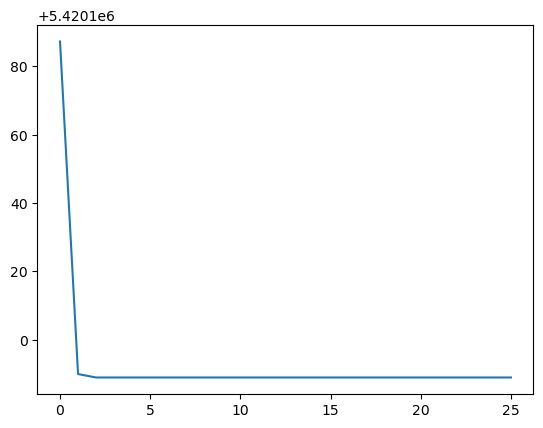

In [79]:
print("minimum loss: ", np.min(np.sum(losses, axis=1)))
    
plt.plot(losses[:,0])
#plt.plot(losses[:,1])
#plt.yscale('log')
plt.show()

minimum loss:  5799492.046875


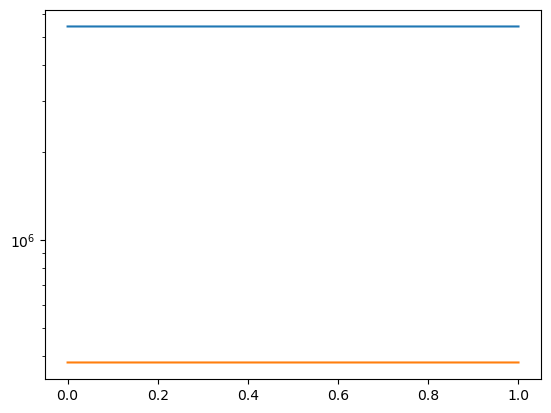

In [13]:

(u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))
def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy))# - to(u_t2)[-1, ...]
v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy))# - to(v_t2)[-1, ...]
# X and Y are misoriented
u_der = u_der.T
v_der = v_der.T

u = pattern.c[0,:, : , -1]
v = pattern.c[1,:, : , -1]
f = u * u * v / (1.0 + kappa_u * u * u)
f_u =    rho_u * f - mu_u * u + sigma_u
f_v =  - rho_v * f + sigma_v

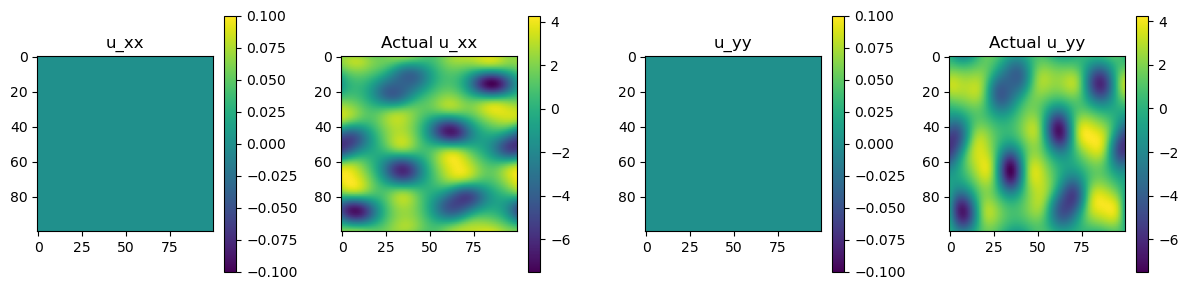

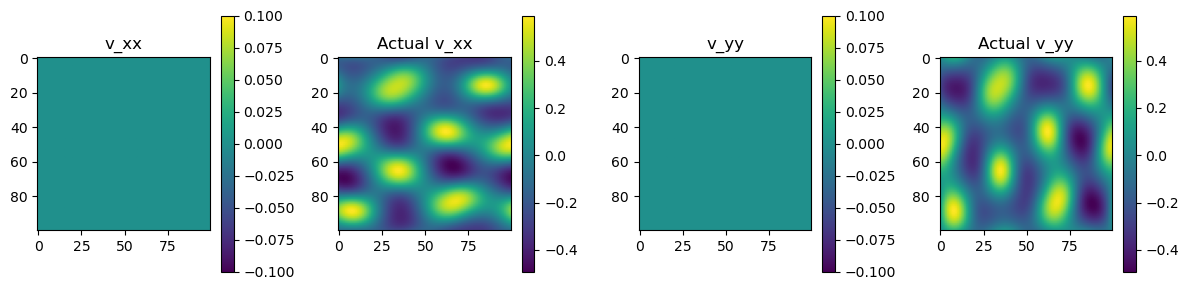

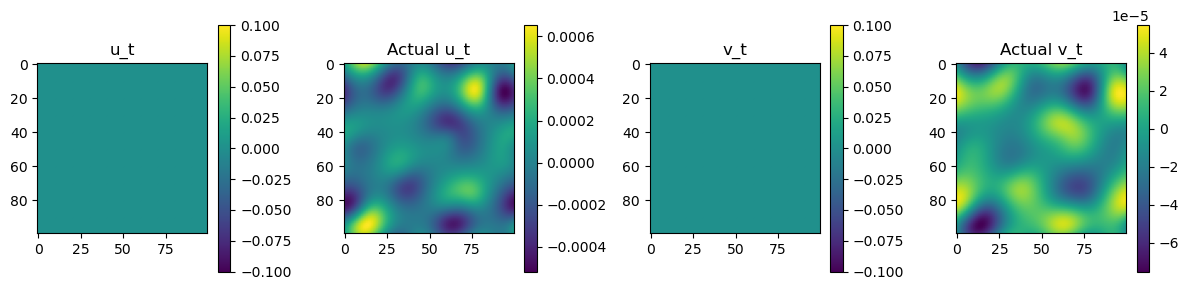

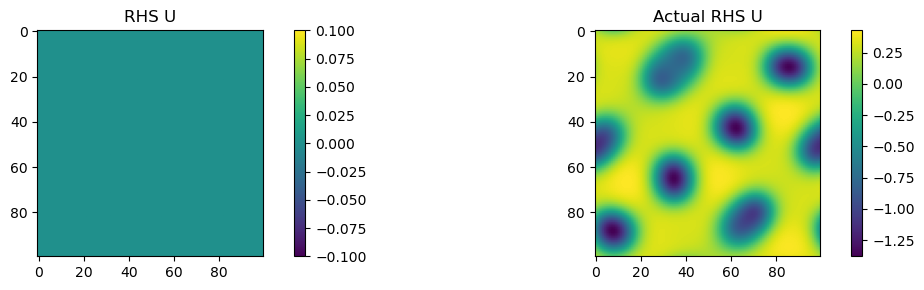

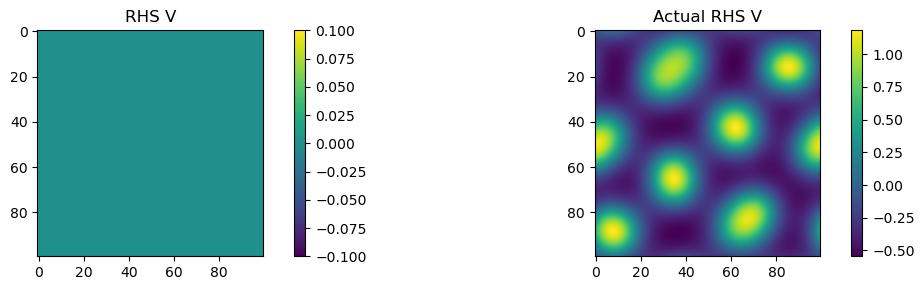

In [14]:
plot_n_im([to(u_xx).T, pattern.c_xx[0,:, : , -1], to(u_yy).T, pattern.c_yy[0,:, : , -1]], 
          ["u_xx", "Actual u_xx", "u_yy", "Actual u_yy"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([to(v_xx).T, pattern.c_xx[1,:, : , -1], to(v_yy).T, pattern.c_yy[1,:, : , -1]],
          ["v_xx", "Actual v_xx", "v_yy", "Actual v_yy"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([to(u_t).T,  pattern.c_t[0,:, : , -1],  to(v_t).T,  pattern.c_t[1,:, : , -1]],
          ["u_t", "Actual u_t", "v_t", "Actual v_t"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([u_der,  actual_u_der],
          ["RHS U", "Actual RHS U"],          
          figsize=(12, 3)); plt.tight_layout()
plot_n_im([v_der,  actual_v_der],
          ["RHS V", "Actual RHS V"],          
          figsize=(12, 3)); plt.tight_layout()

### - $\frac{\partial u}{\partial t} =  D_u (\partial_{x x} + \partial_{y y}) u
 + \rho_u \frac{u v}{1 + \kappa_u u^2} - \mu_u u + \sigma_u$
### - $\frac{\partial v}{\partial t} =  D_v (\partial_{x x} + \partial_{y y}) v
 - \rho_v \frac{u^2 v}{1 + \kappa_u u^2} + \sigma_v$